# Creating Models for San Juan

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
plt.rcParams["font.family"] = "serif"
plt.rcParams["pdf.fonttype"] = 42
sj_new = pd.read_csv("./sj_less_columns.csv")
sj_new.describe()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,936.000000,745.000000,887.000000,917.000000,917.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,26.503205,0.057925,0.067469,0.177655,0.165956,78.568181,16.552409,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,15.021909,0.107153,0.092479,0.057166,0.056073,3.389488,1.560923,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,66.735714,11.715714,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,13.750000,0.004500,0.016425,0.139283,0.129157,76.246071,15.236429,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,26.500000,0.057700,0.068075,0.177186,0.165971,78.667857,16.845714,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,39.250000,0.111100,0.115200,0.212557,0.202771,80.963214,17.858571,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,53.000000,0.493400,0.437100,0.393129,0.381420,87.575714,19.440000,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


In [2]:
sj_test = pd.read_csv("./sj_test_less_columns.csv")
Year = sj_test['year']
sj_test.drop(['year'], axis=1, inplace=True)
sj_test


,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,18,-0.01890,-0.018900,0.102729,0.091200,78.781429,15.918571,26.528571,7.057143,33.3,21.7,75.2
1,19,-0.01800,-0.012400,0.082043,0.072314,78.230000,15.791429,26.071429,5.557143,30.0,22.2,34.3
2,20,-0.00150,NaN,0.151083,0.091529,78.270000,16.674286,27.928571,7.785714,32.8,22.8,3.0
3,21,NaN,-0.019867,0.124329,0.125686,73.015714,15.775714,28.057143,6.271429,33.3,24.4,0.3
4,22,0.05680,0.039833,0.062267,0.075914,74.084286,16.137143,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...
255,13,-0.08740,-0.016183,0.156343,0.105186,78.780000,15.985714,27.542857,7.942857,33.9,22.8,3.5
256,14,-0.20325,-0.077833,0.204171,0.178914,81.650000,15.881429,26.642857,6.642857,33.3,22.8,17.6
257,15,-0.11760,-0.008200,0.192700,0.170429,78.285714,16.212857,27.914286,8.114286,32.8,23.3,9.4
258,16,0.08275,0.031200,0.135014,0.074857,77.674286,15.965714,27.728571,6.942857,31.7,23.9,22.9


The following cell replaces the NaN values with the mean of the cells' values above and below the cell with NaN 

In [3]:
# assume 'df' is a dataframe containing NaN values in multiple columns
for col in sj_new.columns:
    temp = sj_new[col].to_numpy()  # convert the column to a numpy array for faster processing
    
    # fill NaN values with the mean of the previous and next valid values
    mask = sj_new[col].isnull()
    temp[mask] = pd.Series(temp).fillna(method='ffill').add(pd.Series(temp).fillna(method='bfill')).div(2).values[mask]

    # assign the updated values back to the dataframe column
    sj_new[col] = pd.Series(temp)


In [4]:
# assume 'df' is a dataframe containing NaN values in multiple columns
for col in sj_test.columns:
    temp = sj_test[col].to_numpy()  # convert the column to a numpy array for faster processing
    
    # fill NaN values with the mean of the previous and next valid values
    mask = sj_test[col].isnull()
    temp[mask] = pd.Series(temp).fillna(method='ffill').add(pd.Series(temp).fillna(method='bfill')).div(2).values[mask]

    # assign the updated values back to the dataframe column
    sj_test[col] = pd.Series(temp)


In [5]:
threshold_prec = sj_new['station_precip_mm'].quantile(0.975)
threshold_cases = sj_new['total_cases'].quantile(0.975)

# Applying the thresholds into the df
sj_new.loc[sj_new['station_precip_mm'] > threshold_prec, 'station_precip_mm'] = threshold_prec
sj_new.loc[sj_new['total_cases'] > threshold_cases, 'total_cases'] = threshold_cases

min_val = sj_new['total_cases'].min()
max_val = sj_new['total_cases'].max()

print(min_val)
print(max_val)

0.0
163.375


In [6]:
sj_new['weekofyear'] =  sj_new['weekofyear'] / 53
sj_new['reanalysis_relative_humidity_percent'] = sj_new['reanalysis_relative_humidity_percent'] / 100
sj_new['reanalysis_specific_humidity_g_per_kg'] =  sj_new['reanalysis_specific_humidity_g_per_kg'] / 20

# select columns to normalize with StandardScaler and MinMaxScaler
columns_minmax = ['station_precip_mm', 'total_cases']
columns_standard = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']

# normalize columns with StandardScaler
scaler_standard = StandardScaler()
sj_new[columns_standard] = scaler_standard.fit_transform(sj_new[columns_standard])

# normalize columns with MinMaxScaler
scaler_minmax = MinMaxScaler()
sj_new[columns_minmax] = scaler_minmax.fit_transform(sj_new[columns_minmax])

In [7]:

# Applying the thresholds into the df
sj_test.loc[sj_test['station_precip_mm'] > threshold_prec, 'station_precip_mm'] = threshold_prec
#sj_test.loc[sj_test['total_cases'] > threshold_cases, 'total_cases'] = threshold_cases


sj_test['weekofyear'] =  sj_test['weekofyear'] / 53
sj_test['reanalysis_relative_humidity_percent'] = sj_test['reanalysis_relative_humidity_percent'] / 100
sj_test['reanalysis_specific_humidity_g_per_kg'] =  sj_test['reanalysis_specific_humidity_g_per_kg'] / 20



# select columns to normalize with StandardScaler and MinMaxScaler
columns_minmax = ['station_precip_mm']
columns_standard = ['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']

# normalize columns with StandardScaler

sj_test[columns_standard] = scaler_standard.fit_transform(sj_test[columns_standard])

sj_test[columns_minmax] = scaler_minmax.fit_transform(sj_test[columns_minmax])

In [8]:
sj_test.describe()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,2.600000e+02,2.600000e+02,2.600000e+02,2.600000e+02,260.000000
mean,0.500073,0.024490,0.037349,0.177095,0.153210,0.781830,0.837076,7.348822e-16,3.010412e-16,1.572460e-15,1.264800e-15,0.315712
std,0.283848,0.127483,0.086986,0.066747,0.055021,0.034014,0.084058,1.001929e+00,1.001929e+00,1.001929e+00,1.001929e+00,0.294046
min,0.018868,-0.463400,-0.211800,0.006200,-0.014671,0.649200,0.626857,-2.187879e+00,-3.081688e+00,-2.617883e+00,-2.065927e+00,0.000000
25%,0.259434,-0.044687,-0.010650,0.131929,0.116486,0.760379,0.767929,-8.437380e-01,-6.614680e-01,-7.130255e-01,-9.309576e-01,0.070751
50%,0.500000,0.014100,0.031960,0.169411,0.148580,0.783357,0.851643,1.026984e-01,3.747489e-02,1.961215e-02,-2.965814e-02,0.217922
75%,0.740566,0.079600,0.078100,0.218082,0.191275,0.804214,0.909107,8.830051e-01,6.320980e-01,6.643333e-01,8.716413e-01,0.475780
max,1.000000,0.500400,0.649000,0.385383,0.318129,0.867814,0.967000,2.121427e+00,3.281822e+00,1.953776e+00,2.407188e+00,1.000000


## Selecting target feature

In [9]:
X_sj = sj_new.drop(columns = "total_cases")
Y_sj = sj_new.loc[:, "total_cases"]


X_train = X_sj
Y_train = Y_sj

# X_train, X_test, Y_train, Y_test = train_test_split(X_sj, Y_sj, test_size=0.20)
print("Shape of x_train:", X_train.shape)
print("Shape of y_train:", Y_train.shape)
# print("Shape of x_test:", X_test.shape)
# print("Shape of y_test:", Y_test.shape)

Shape of x_train: (936, 12)
Shape of y_train: (936,)


# Model Choice
## Linear Model Regressor (Baseline)

In [10]:
lr_model = LinearRegression()

lr_model.fit(X_train, Y_train)
#lr_model_pred_test = lr_model.predict(X_test)
lr_model_pred_train = lr_model.predict(X_train)



rmse_lr_train = mean_squared_error(Y_train, lr_model_pred_train, squared=False) 
mae_lr_train = mean_absolute_error(Y_train, lr_model_pred_train)

# rmse_lr_test = mean_squared_error(Y_test, lr_model_pred_test, squared=False) 
# mae_lr_test = mean_absolute_error(Y_test, lr_model_pred_test)

print("RMSE Train: {:.3f}".format(rmse_lr_train))
print("MAE Train: {:.3f}".format(mae_lr_train))

# print("RMSE Test: {:.3f}".format(rmse_lr_test))
# print("MAE Test: {:.3f}".format(mae_lr_test))

RMSE Train: 0.195
MAE Train: 0.136


## Decision Tree Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [11]:
# dt_model = DecisionTreeRegressor()
# # create a grid search object

# param_grid = {
#     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
#     'max_depth': [5, 10, 15]
# }

# grid_search = GridSearchCV(dt_model, param_grid, cv=5)

# # fit the grid search object to the training data
# grid_search.fit(X_train, Y_train)

# # get the best hyperparameters
# best_params = grid_search.best_params_

# # create a new random forest regressor with the best hyperparameters
# dt_model = DecisionTreeRegressor(max_depth=best_params['max_depth'], criterion=best_params["criterion"])

# # fit the model to the training data
# dt_model.fit(X_train, Y_train)

# # generate predictions on the training data
# dt_train_pred = dt_model.predict(X_train)

# # evaluate the model on the test data
# dt_test_pred = dt_model.predict(X_test)

# rmse_dt = mean_squared_error(Y_test, dt_test_pred, squared=False)
# mae_dt = mean_absolute_error(Y_test, dt_test_pred)

# print("Best Hyperparameters: ", best_params)
# print("RMSE: {:.3f}".format(rmse_dt))
# print("MAE: {:.3f}".format(mae_dt))

In [12]:
dt_model = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)

dt_model.fit(X_train, Y_train)

# generate predictions on the training data
dt_train_pred = dt_model.predict(X_train)

# evaluate the model on the test data
# dt_test_pred = dt_model.predict(X_test)

rmse_dt_train = mean_squared_error(Y_train, dt_train_pred, squared=False)
mae_dt_train = mean_absolute_error(Y_train, dt_train_pred)

print("RMSE Train: {:.3f}".format(rmse_dt_train))
print("MAE Train: {:.3f}".format(mae_dt_train))

# rmse_dt_test = mean_squared_error(Y_test, dt_test_pred, squared=False)
# mae_dt_test = mean_absolute_error(Y_test, dt_test_pred)
# print("RMSE Test: {:.3f}".format(rmse_dt_test))
# print("MAE Test: {:.3f}".format(mae_dt_test))

RMSE Train: 0.136
MAE Train: 0.091


## Random Forest Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [13]:
# # create a random forest regressor object
# rf_model = RandomForestRegressor()

# # define the grid search parameters
# param_grid = {
#     "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [5, 10, 15]
# }

# # create a grid search object
# grid_search = GridSearchCV(rf_model, param_grid, cv=5)

# # fit the grid search object to the training data
# grid_search.fit(X_train, Y_train)

# # get the best hyperparameters
# best_params = grid_search.best_params_

# # create a new random forest regressor with the best hyperparameters
# rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], criterion=best_params["criterion"])

# # fit the model to the training data
# rf_model.fit(X_train, Y_train)

# # generate predictions on the training data
# rf_train_pred = rf_model.predict(X_train)

# # evaluate the model on the test data
# rf_test_pred = rf_model.predict(X_test)

# rmse_rf = mean_squared_error(Y_test, rf_test_pred, squared=False)
# mae_rf = mean_absolute_error(Y_test, rf_test_pred)

# print("Best Hyperparameters: ", best_params)
# print("RMSE: {:.3f}".format(rmse_rf))
# print("MAE: {:.3f}".format(mae_rf))


In [14]:
rf_model = RandomForestRegressor(criterion='friedman_mse', n_estimators=100, max_depth=10)
# fit the model to the training data
rf_model.fit(X_train, Y_train)

# generate predictions on the training data
rf_train_pred = rf_model.predict(X_train)

# evaluate the model on the test data
# rf_test_pred = rf_model.predict(X_test)


rmse_rf_train = mean_squared_error(Y_train, rf_train_pred, squared=False)
mae_rf_train = mean_absolute_error(Y_train, rf_train_pred)

print("RMSE Train: {:.3f}".format(rmse_rf_train))
print("MAE Train: {:.3f}".format(mae_rf_train))

# rmse_rf_test = mean_squared_error(Y_test, rf_test_pred, squared=False)
# mae_rf_test = mean_absolute_error(Y_test, rf_test_pred)
# print("RMSE Test: {:.3f}".format(rmse_rf_test))
# print("MAE Test: {:.3f}".format(mae_rf_test))

RMSE Train: 0.077
MAE Train: 0.054


## Neural Network Regressor

Uncommment the cell below to perform a gridsearch for the best hyperparameters.

In [15]:
# # Define the hyperparameters to search over
# NN_model = MLPRegressor()
# params = {
#     'hidden_layer_sizes': [(64,), (32, 16), (64, 32, 16)],
#     'max_iter': [500, 1000, 2000],
#     'activation': ['relu', 'tanh', 'logistic']
# }

# # Perform a grid search over the hyperparameters
# grid_search = GridSearchCV(NN_model, param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, Y_train)

# # Print the best hyperparameters and the associated mean test score
# print("Best hyperparameters:", grid_search.best_params_)

# # Use the best model to make predictions on the training and testing data
# best_model = grid_search.best_estimator_
# Y_pred_train = best_model.predict(X_train)
# Y_pred_test = best_model.predict(X_test)

# # Compute the RMSE and MAE for the training and testing data
# rmse_train = mean_squared_error(Y_train, Y_pred_train, squared=False)
# mae_train = mean_absolute_error(Y_train, Y_pred_train)
# print("RMSE Train: {:.3f}".format(rmse_train))
# print("MAE Train: {:.3f}".format(mae_train))

# rmse_test = mean_squared_error(Y_test, Y_pred_test, squared=False)
# mae_test = mean_absolute_error(Y_test, Y_pred_test)
# print("RMSE Test: {:.3f}".format(rmse_test))
# print("MAE Test: {:.3f}".format(mae_test))

In [16]:
NN_model = MLPRegressor(activation='relu', hidden_layer_sizes=(256, 128, 64), max_iter=500, alpha = 0.0001)

# Train the model on the training data
NN_model.fit(X_train, Y_train)

# Test the model on the testing data and print the accuracy score
Y_pred_NN_train = NN_model.predict(X_train)
# Y_pred_NN_test = NN_model.predict(X_test)

rmse_train_nn = mean_squared_error(Y_train, Y_pred_NN_train, squared=False)
mae_train_nn = mean_absolute_error(Y_train, Y_pred_NN_train)
print("RMSE Train: {:.3f}".format(rmse_train_nn))
print("MAE Train: {:.3f}".format(mae_train_nn))

# rmse_test_nn = mean_squared_error(Y_test, Y_pred_NN_test, squared=False)
# mae_test_nn = mean_absolute_error(Y_test, Y_pred_NN_test)
# print("RMSE Test: {:.3f}".format(rmse_test_nn))
# print("MAE Test: {:.3f}".format(mae_test_nn))

RMSE Train: 0.194
MAE Train: 0.132


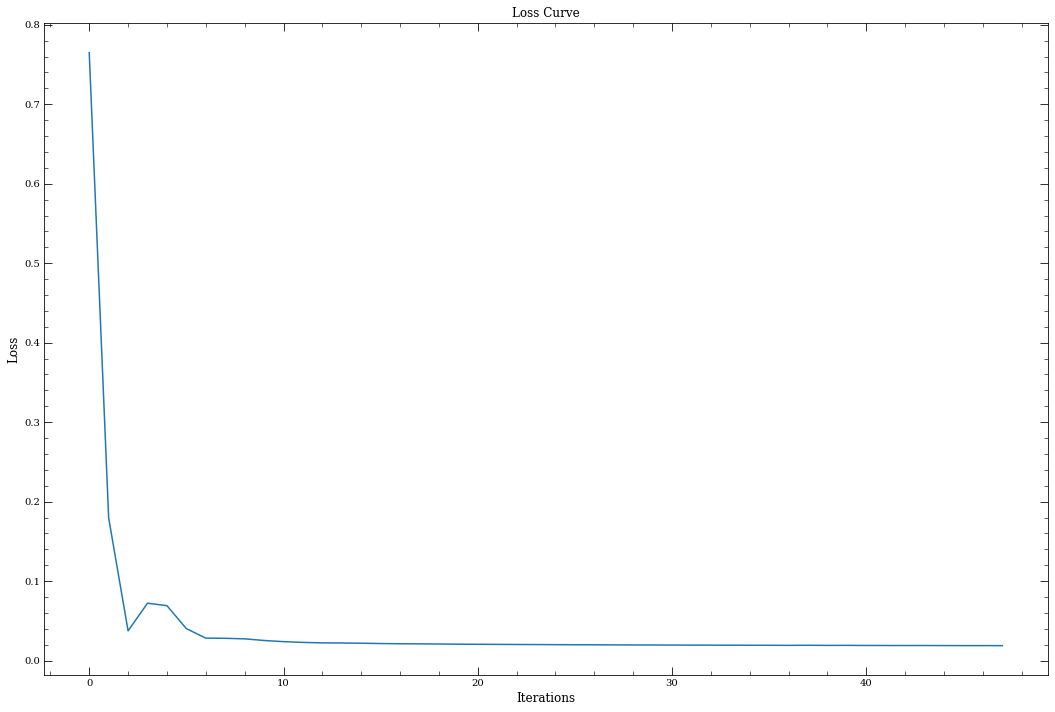

In [17]:
plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1)
ax.minorticks_on()
ax.xaxis.set_ticks_position("both")
ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
plt.title("Loss Curve", fontsize=12)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.plot(NN_model.loss_curve_);

## eXtreme Gradient Boosting (XGB) Regressor

In [18]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# #Define the XGBoost model
# xgb_model = xgb.XGBRegressor(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'colsample_bytree': [0.5, 0.7, 1.0],
# }

# # Perform grid search
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=2
# )

# grid_search.fit(X_train, Y_train, early_stopping_rounds=10, eval_set=[(X_test, Y_test)], verbose=False)

# # Print the best hyperparameters and the corresponding RMSE
# print("Best hyperparameters: ", grid_search.best_params_)
# y_train_pred = grid_search.predict(X_train)
# rmse_train = mean_squared_error(Y_train, y_train_pred, squared=False)
# print(f'RMSE_train: {rmse_train:.2f}')

# test_predictions = grid_search.predict(X_test)
# rmse_test = mean_squared_error(Y_test, test_predictions, squared=False)
# print(f'RMSE_test: {rmse_test:.2f}')

In [19]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
#Define the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, colsample_bytree = 0.7, max_depth=6)

xgb_model.fit(X_train, Y_train, verbose=False)

y_train_pred = xgb_model.predict(X_train)
rmse_train_xgb = mean_squared_error(Y_train, y_train_pred, squared=False)
mae_train_xgb = mean_absolute_error(Y_train, y_train_pred)
print(f'RMSE Train: {rmse_train_xgb:.3f}')
print(f'MAE Train: {mae_train_xgb:.3f}')

# y_test_pred = xgb_model.predict(X_test)
# rmse_test_xgb = mean_squared_error(Y_test, y_test_pred, squared=False)
# mae_test_xgb = mean_absolute_error(Y_test, y_test_pred)
# print(f'RMSE Test: {rmse_test_xgb:.3f}')
# print(f'MAE Test: {mae_test_xgb:.3f}')

RMSE Train: 0.061
MAE Train: 0.045


## Plotting of Top Regressor Model

In [20]:
# rmse_train_values = [rmse_lr_train, rmse_dt_train, rmse_rf_train , rmse_train_nn, rmse_train_xgb]
# rmse_test_values = [rmse_lr_test, rmse_dt_test, rmse_rf_test , rmse_test_nn, rmse_test_xgb]

# mae_train_values = [mae_lr_train, mae_dt_train, mae_rf_train , mae_train_nn, mae_train_xgb]
# mae_test_values = [mae_lr_test, mae_dt_test, mae_rf_test , mae_test_nn, mae_test_xgb]

# model_labels = ['Linear Model', 'Decision Tree', 'Random Forest', 'Neural Network', 'XGB']

# train_positions = np.arange(len(model_labels))
# test_positions = train_positions + 0.2  # Add a small offset to separate the bars

# # Set the figure size
# plt.figure(figsize=(18, 12))
# ax1 = plt.subplot(1, 2, 1)
# ax1.bar(train_positions, rmse_train_values, color='lightcoral', width=0.2, label='Train');
# ax1.bar(test_positions, rmse_test_values, color='firebrick', width=0.2, label='Test');
# ax1.set_title('RMSE of Train and Test Sets', fontsize=12)
# ax1.set_ylabel('RMSE', fontsize=12)
# ax1.set_ylim(0,0.25)
# ax1.set_xticks(train_positions + 0.1, model_labels, fontsize=10)
# ax1.legend(loc="best")
# ax1.minorticks_on()
# ax1.xaxis.set_ticks_position("both")
# ax1.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax1.tick_params(top=True, right=True, which='minor', direction='in', length=4)

# ax2 = plt.subplot(1, 2, 2)
# ax2.bar(train_positions, mae_train_values, color='lightcoral', width=0.2, label='Train');
# ax2.bar(test_positions, mae_test_values, color='firebrick', width=0.2, label='Test');
# ax2.set_title('MAE of Train and Test Sets', fontsize=12)
# ax2.set_ylabel('MAE', fontsize=12)
# ax2.set_ylim(0,0.25)
# ax2.set_xticks(train_positions + 0.1, model_labels, fontsize=10)
# ax2.legend(loc="best")
# ax2.minorticks_on()
# ax2.xaxis.set_ticks_position("both")
# ax2.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax2.tick_params(top=True, right=True, which='minor', direction='in', length=4)



# # Show the plot
# plt.tight_layout()
# plt.savefig('sj_new_20.pdf')
# plt.show();

In [21]:
# # create scatter plot of predicted vs actual values for test data
# plt.figure(figsize=(18, 12))
# ax = plt.subplot(1, 1, 1)
# plt.scatter(rf_test_pred, Y_test, color="blue")

# slope, intercept = np.polyfit(rf_test_pred, Y_test, 1)
# x = np.linspace(min(rf_test_pred), max(rf_test_pred), 100)
# y = slope * x + intercept

# # create scatter plot of predicted vs actual values for test data
# plt.scatter(rf_test_pred, Y_test, color = "blue")
# plt.plot(x, y, color='red')

# plt.title('Random Forest Regression Model', fontsize = 12)
# plt.xlabel('Predicted Values', fontsize = 12)
# plt.ylabel('Actual Values', fontsize = 12)

# ax.minorticks_on()
# ax.xaxis.set_ticks_position("both")
# ax.tick_params(top=True, right=True, which='major', direction='in', length=8, labelbottom=True, labeltop=False)
# ax.tick_params(top=True, right=True, which='minor', direction='in', length=4)
# plt.tight_layout()
# plt.show();

In [28]:
print(min_val)
print(max_val)

0.0
163.375


In [38]:
#predictions = xgb_model.predict(sj_test)
#predictions = rf_model.predict(sj_test)
#predictions = NN_model.predict(sj_test)
#predictions = lr_model.predict(sj_test)
predictions = dt_model.predict(sj_test)

predictions = predictions * (max_val - min_val) + min_val

predictions = predictions.astype(int)
week = (sj_test['weekofyear']*53).astype(int)

In [39]:
submission = pd.DataFrame(predictions, columns=["total_cases"])
submission.insert(0, 'city', "sj")
submission.insert(1, 'year', Year)
submission.insert(2, 'weekofyear', week)
submission.reset_index()
submission.to_csv('Submission_dt.csv', index = False)

In [40]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,12
2,sj,2008,20,12
3,sj,2008,21,12
4,sj,2008,22,12
...,...,...,...,...
255,sj,2013,13,12
256,sj,2013,14,12
257,sj,2013,15,12
258,sj,2013,16,12
